In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
csv_path = "Cardiotocographic.csv"
df_raw = pd.read_csv(csv_path)
df = df_raw.copy()
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
for col in df.columns:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "").str.strip(), errors="ignore")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]
print(df.shape); df.head()

(2126, 14)


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Tendency,NSP
0,120.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,0.999926,2.0
1,132.000000,0.006380,0.0,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,10.4,130.0,0.000000,1.0
2,133.000000,0.003322,0.0,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,13.4,130.0,0.000000,1.0
3,134.000000,0.002561,0.0,0.007742,0.002561,0.0,0.0,16.0,2.4,0.0,23.0,117.0,1.000000,1.0
4,131.948232,0.006515,0.0,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,1.000000,1.0


In [3]:
missing_counts = df.isna().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_pct}).sort_values('missing_count', ascending=False)
missing_summary

,missing_count,missing_pct
LB,21,0.987770
DS,21,0.987770
MLTV,21,0.987770
Width,21,0.987770
Tendency,21,0.987770
DP,21,0.987770
NSP,21,0.987770
AC,20,0.940734
FM,0,0.000000
UC,0,0.000000


In [4]:
df_imputed = df.copy()
for col in numeric_cols:
    if df_imputed[col].isna().any():
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
for col in categorical_cols:
    if df_imputed[col].isna().any():
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode(dropna=True).iloc[0])
df_imputed.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Tendency,NSP
0,120.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,0.999926,2.0
1,132.000000,0.006380,0.0,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,10.4,130.0,0.000000,1.0
2,133.000000,0.003322,0.0,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,13.4,130.0,0.000000,1.0
3,134.000000,0.002561,0.0,0.007742,0.002561,0.0,0.0,16.0,2.4,0.0,23.0,117.0,1.000000,1.0
4,131.948232,0.006515,0.0,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,1.000000,1.0


In [5]:
outlier_info = []
df_no_outliers = df_imputed.copy()
for col in numeric_cols:
    q1 = df_imputed[col].quantile(0.25)
    q3 = df_imputed[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((df_imputed[col] < lower) | (df_imputed[col] > upper)).sum()
    outlier_info.append({'column': col, 'q1': q1, 'q3': q3, 'iqr': iqr, 'lower_fence': lower, 'upper_fence': upper, 'n_outliers': int(outliers)})
    df_no_outliers[col] = df_no_outliers[col].clip(lower=lower, upper=upper)
pd.DataFrame(outlier_info).sort_values('n_outliers', ascending=False)

,column,q1,q3,iqr,lower_fence,upper_fence,n_outliers
13,NSP,1.000000,1.000000,0.000000,1.000000,1.000000,559
2,FM,0.000000,0.002567,0.002567,-0.003850,0.006416,347
9,ALTV,0.000000,11.000000,11.000000,-16.500000,27.500000,318
6,DP,0.000000,0.000000,0.000000,0.000000,0.000000,284
4,DL,0.000000,0.003289,0.003289,-0.004934,0.008224,125
5,DS,0.000000,0.000000,0.000000,0.000000,0.000000,120
10,MLTV,4.600000,10.800000,6.200000,-4.700000,20.100000,81
8,MSTV,0.700000,1.700000,1.000000,-0.800000,3.200000,80
1,AC,0.000000,0.005606,0.005606,-0.008409,0.014015,43
3,UC,0.001851,0.006536,0.004685,-0.005177,0.013564,13


In [6]:
desc = df_imputed[numeric_cols].describe().T
desc['median'] = df_imputed[numeric_cols].median()
desc['iqr'] = df_imputed[numeric_cols].quantile(0.75) - df_imputed[numeric_cols].quantile(0.25)
desc

,count,mean,std,min,25%,50%,75%,max,median,iqr
LB,2126.0,133.340204,11.214379,51.842487,126.000000,133.000000,140.000000,214.000000,133.000000,14.000000
AC,2126.0,0.003204,0.004373,-0.019284,0.000000,0.001634,0.005606,0.038567,0.001634,0.005606
FM,2126.0,0.009894,0.067540,-0.480634,0.000000,0.000000,0.002567,0.961268,0.000000,0.002567
UC,2126.0,0.004391,0.003340,-0.014925,0.001851,0.004484,0.006536,0.030002,0.004484,0.004685
DL,2126.0,0.001895,0.003343,-0.015393,0.000000,0.000000,0.003289,0.030769,0.000000,0.003289
DS,2126.0,0.000002,0.000141,-0.001353,0.000000,0.000000,0.000000,0.002706,0.000000,0.000000
DP,2126.0,0.000173,0.000836,-0.005348,0.000000,0.000000,0.000000,0.010695,0.000000,0.000000
ASTV,2126.0,46.995984,18.813973,-63.000000,32.000000,49.000000,61.000000,162.000000,49.000000,29.000000
MSTV,2126.0,1.364378,1.173632,-6.600000,0.700000,1.200000,1.700000,13.800000,1.200000,1.000000
ALTV,2126.0,10.285964,21.205041,-91.000000,0.000000,0.000000,11.000000,182.000000,0.000000,11.000000


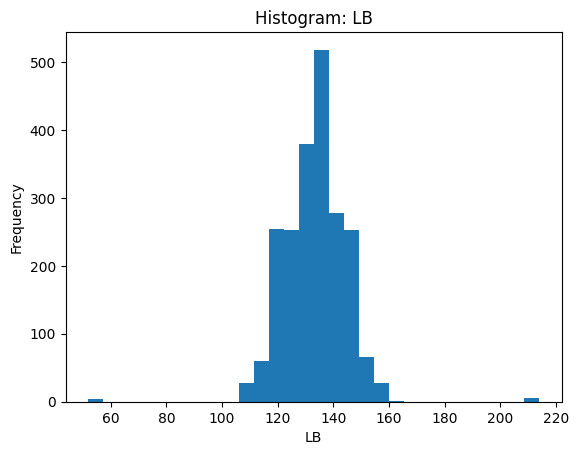

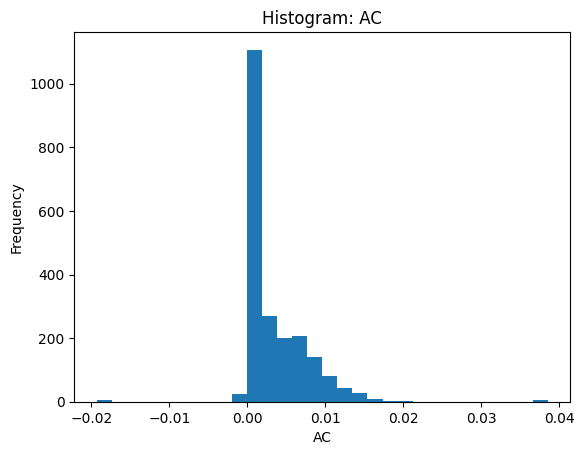

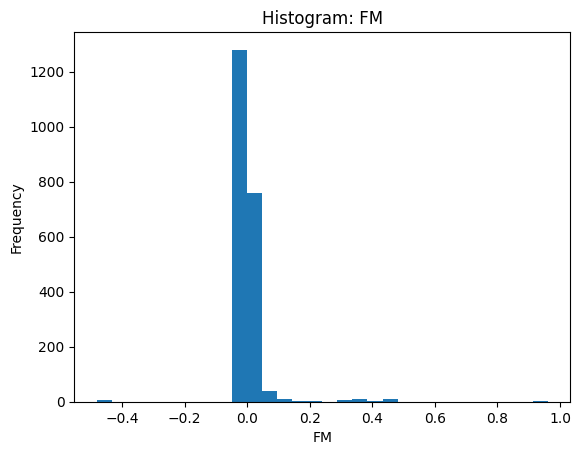

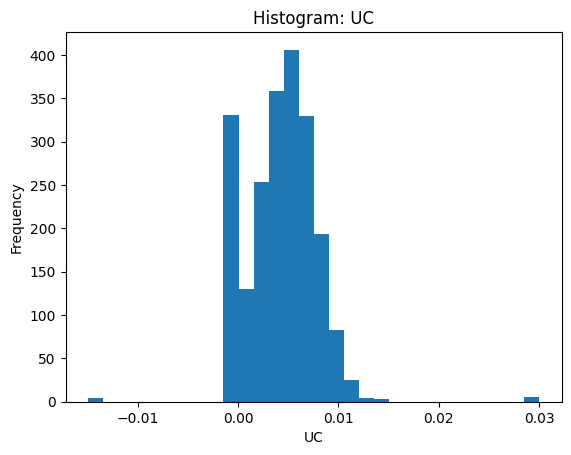

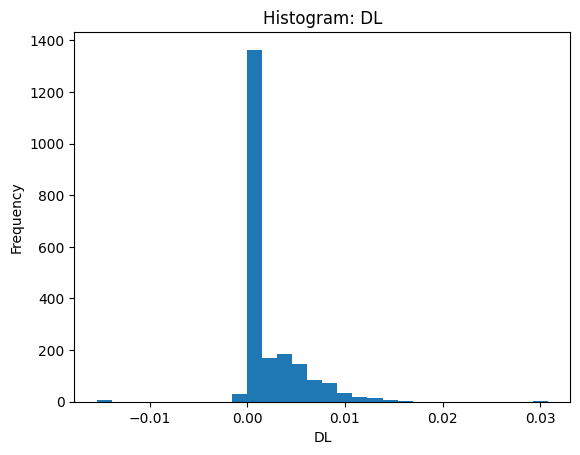

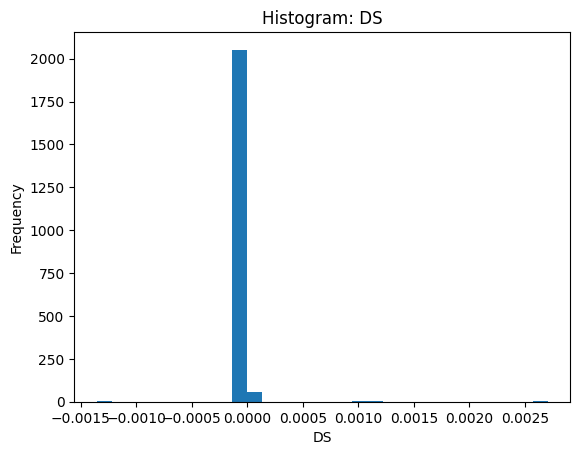

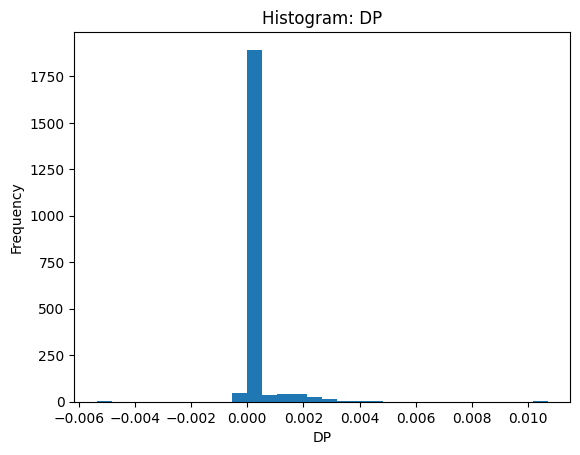

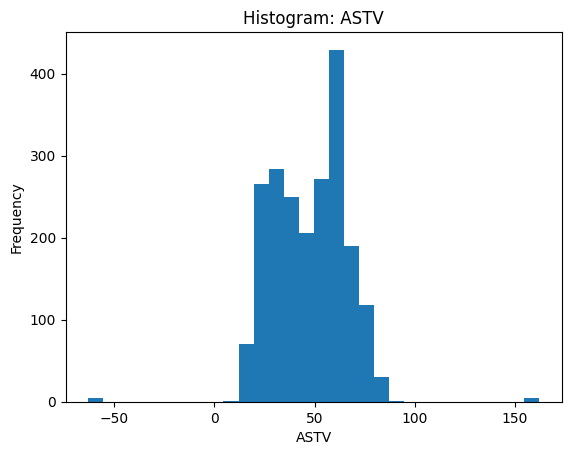

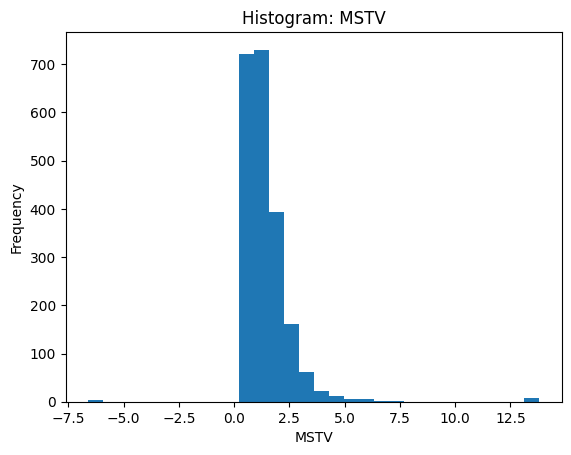

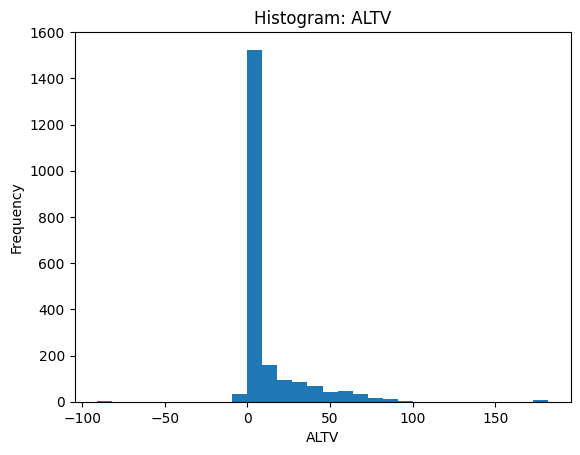

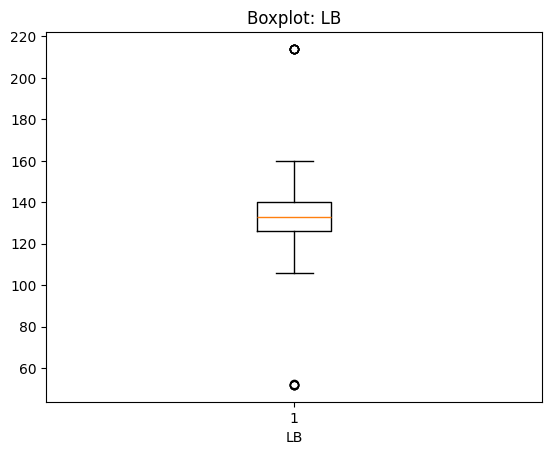

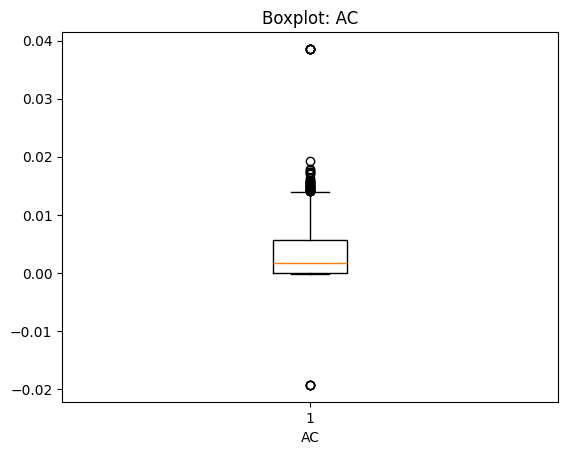

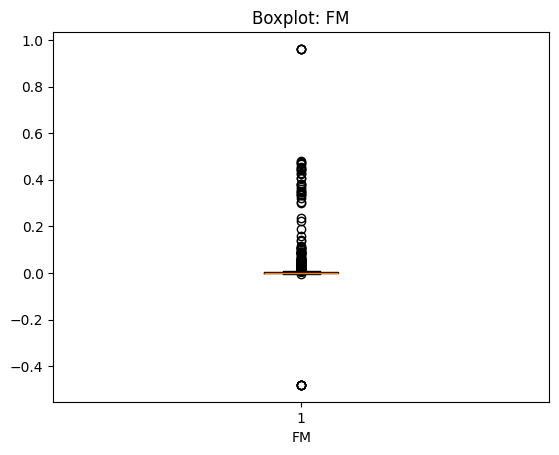

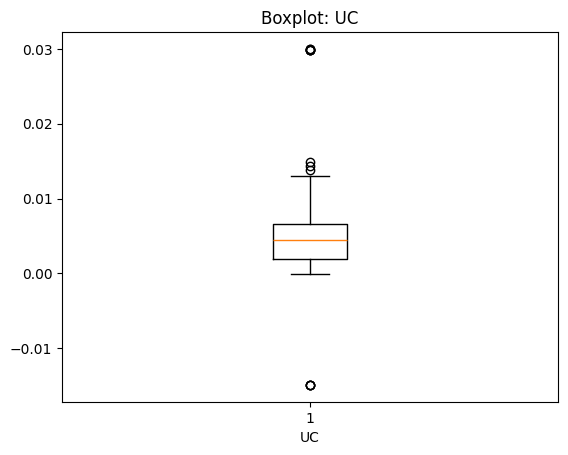

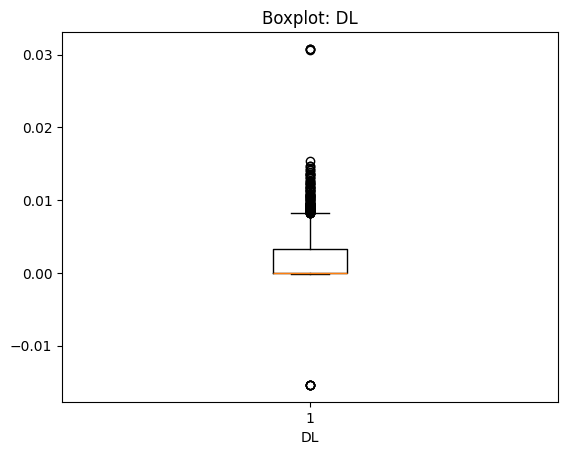

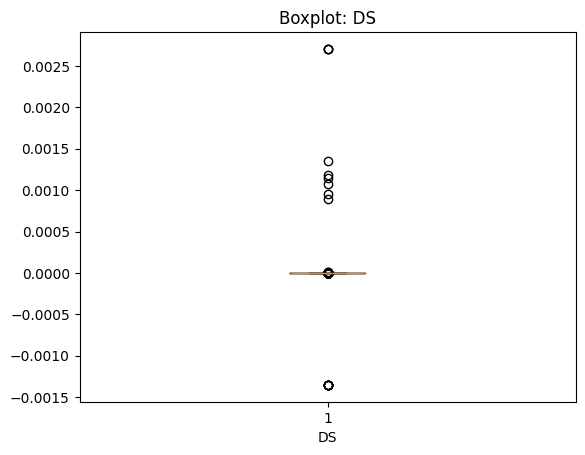

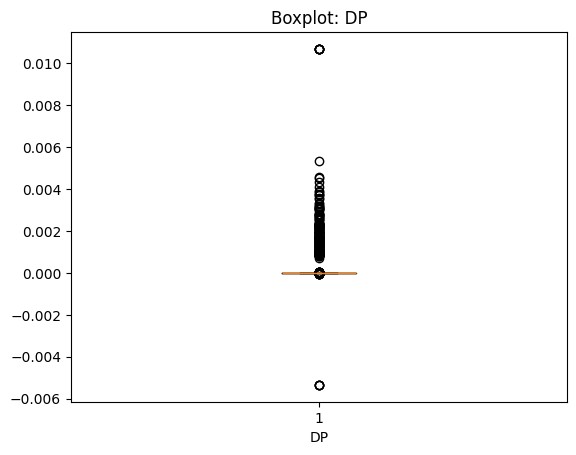

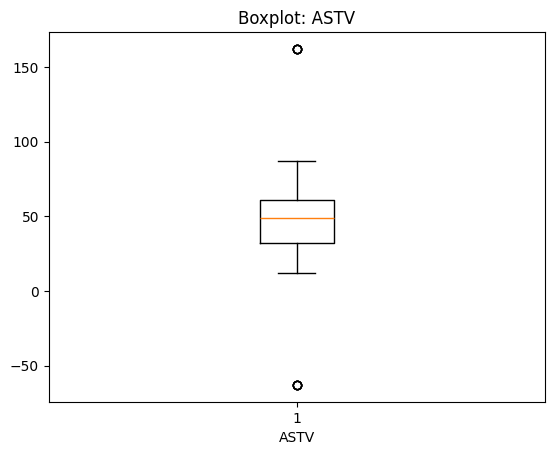

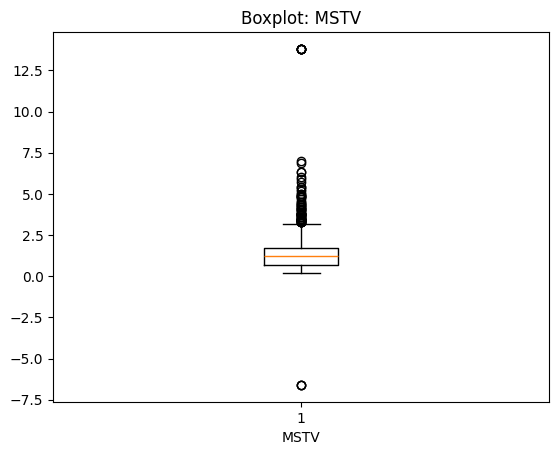

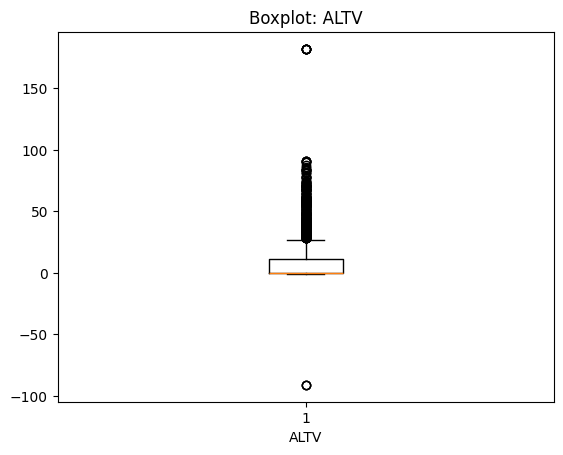

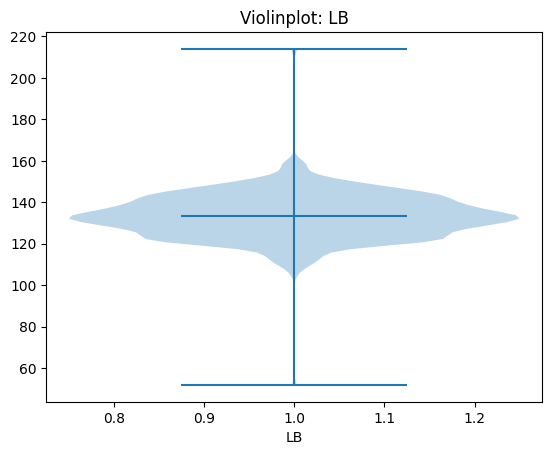

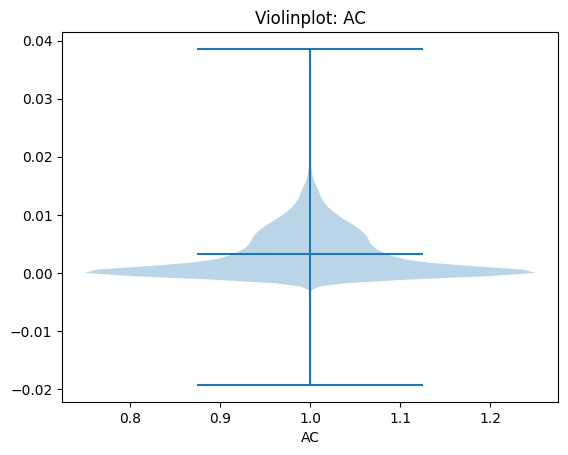

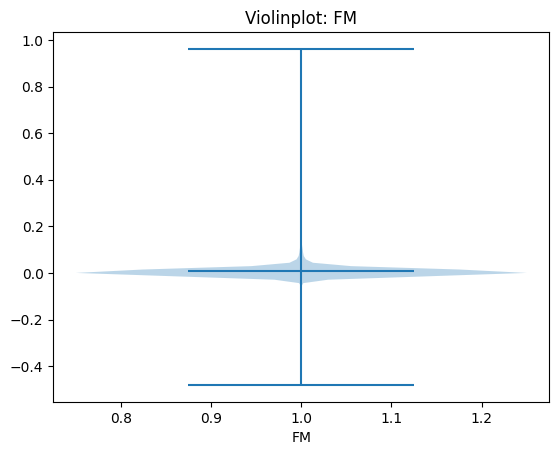

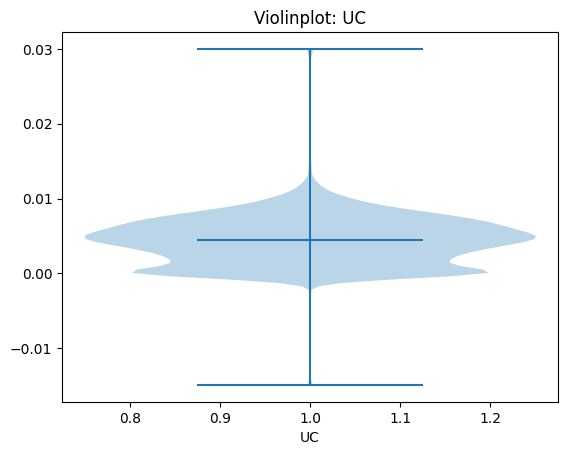

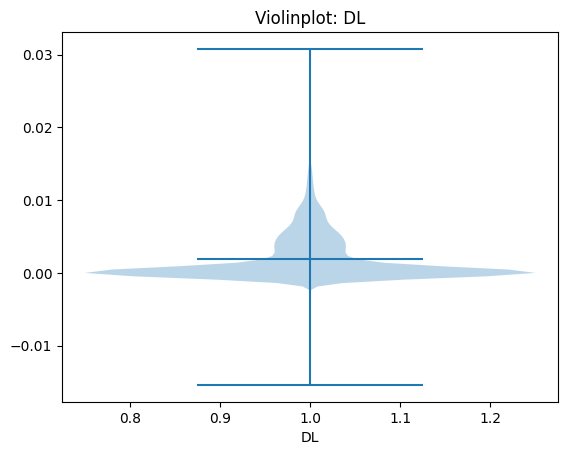

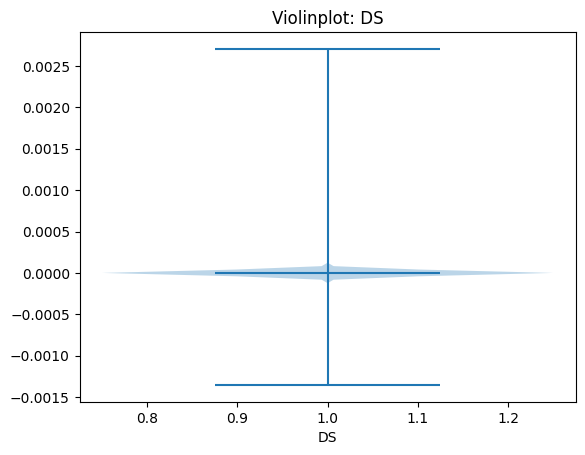

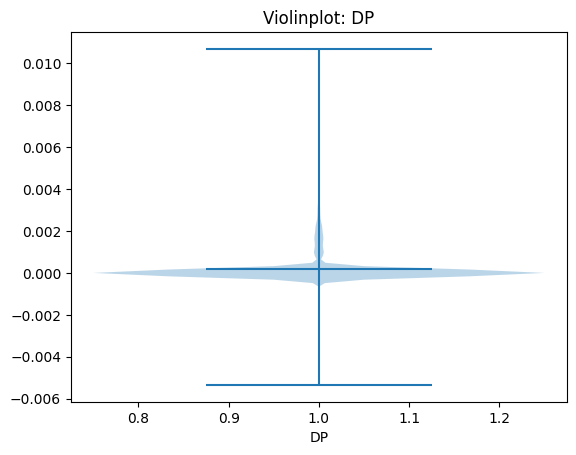

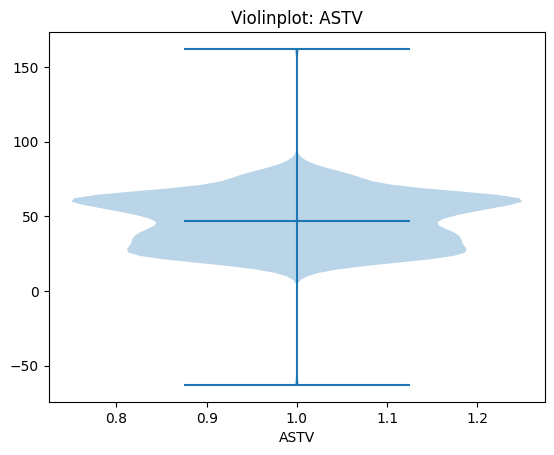

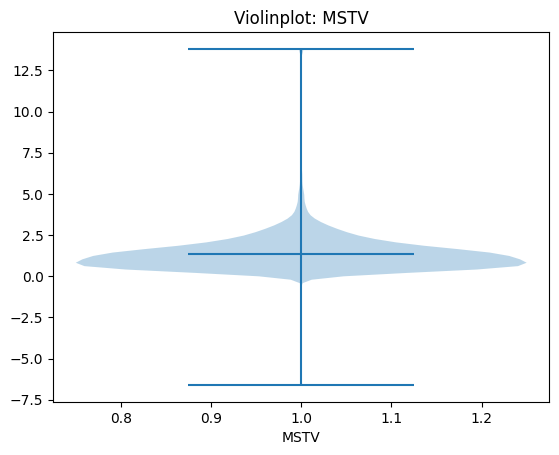

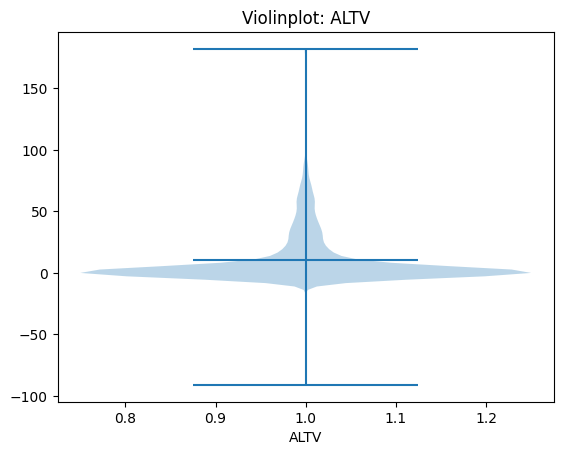

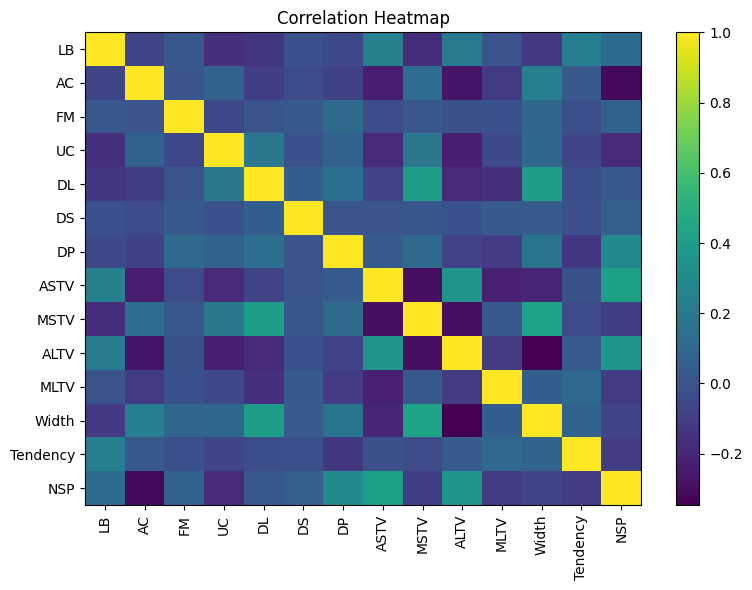

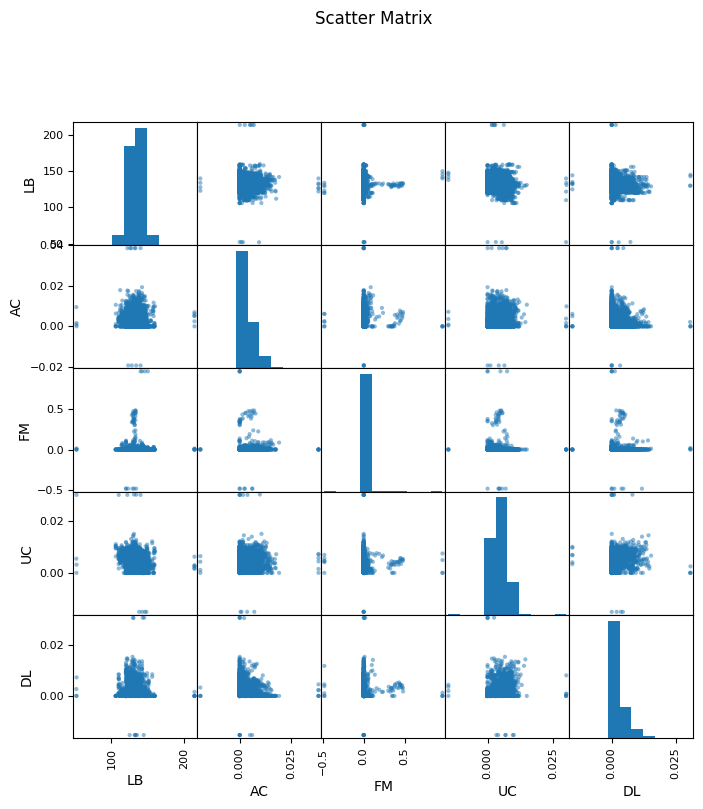

In [7]:
# Histograms
for col in numeric_cols[:10]:
    plt.figure()
    df_imputed[col].dropna().plot(kind='hist', bins=30, title=f'Histogram: {col}')
    plt.xlabel(col)
    plt.show()

# Boxplots
for col in numeric_cols[:10]:
    plt.figure()
    plt.boxplot(df_imputed[col].dropna(), vert=True)
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    plt.show()

# Violin plots
for col in numeric_cols[:10]:
    plt.figure()
    plt.violinplot(df_imputed[col].dropna(), showmeans=True)
    plt.title(f'Violinplot: {col}')
    plt.xlabel(col)
    plt.show()

# Correlation heatmap
corr = df_imputed[numeric_cols].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter matrix
cols = numeric_cols[:5] if len(numeric_cols) >= 5 else numeric_cols
if len(cols) >= 2:
    scatter_matrix(df_imputed[cols].dropna(), diagonal='hist', figsize=(8,8))
    plt.suptitle('Scatter Matrix', y=1.02)
    plt.show()

In [8]:
# Categorical frequency plots
for c in categorical_cols[:3]:
    vc = df_imputed[c].value_counts()
    plt.figure()
    vc.plot(kind='bar', title=f'Bar Chart: {c}')
    plt.xlabel(c); plt.ylabel('Count')
    plt.show()
    plt.figure()
    vc.plot(kind='pie', autopct='%1.1f%%', title=f'Pie Chart: {c}')
    plt.ylabel('')
    plt.show()